# Imports

In [1]:
from data_loader import DataLoader
from calibration import getCalibrationParameters, calibrate
from filtering import medianFilter, lowpassFilter
from ekf import EKF, getEulerAngles
from visualization import run

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = [8, 5]
# plt.style.use('seaborn')
from collections import defaultdict
from typing import List

pygame 2.1.2 (SDL 2.0.18, Python 3.9.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


# Load data

In [2]:
# FILE = "data/Data_Log_2022_11_25_19_07_41.csv"
# FILE = "data/Data_Log_2023_01_14_20_56_19-KULA-BEZ-PODNOSZENIA.csv"
# FILE = "data/Data_Log_2023_01_14_20_54_01-KULA.csv"
# FILE = "data/Data_Log_2023_01_14_21_12_13-CHAOS.csv"
FILE = "data/Data_Log_2023_01_22_16_18_47.csv"

loader = DataLoader(file=FILE)
loader.loadSamples()

Ts = loader.getSamplingPeriod()

w = np.array(loader.getGyroSamples())[3000:, :]
a = np.array(loader.getAccSamples())[3000:, :]
m_raw = np.array(loader.getMagSamples())[3000:, :]

In [3]:
N_START = 500

aBias = np.array([0, 0, 1]) - np.mean(a[:N_START], axis=0)
wBias = np.mean(w[:N_START], axis=0)

print(f'Acc0: {aBias} \nGyro0: {wBias}')

Acc0: [-0.00334   0.009078 -0.026058] 
Gyro0: [-0.237282 -1.171544 -0.725432]


In [4]:
w_var = np.var(w[:N_START], axis=0)
a_var = np.var(a[:N_START], axis=0)
m_var = np.var(m_raw[:N_START], axis=0)
print(f'Acc var: {a_var} \nMag var: {m_var} \nGyro var: {w_var}')

Acc var: [3.92400e-07 3.55916e-07 3.46636e-07] 
Mag var: [0.245539   0.24373776 0.26084736] 
Gyro var: [0.00084005 0.00075738 0.00046652]


# Calibrate magnetometer

In [5]:
# A, b = getCalibrationParameters()
A = np.array([[0.80867134, -0.04579711, 0.02316166],
              [0., 0.82352455, 0.0508741],
              [0., 0., 0.80435273]])
b = np.array([-28.58534364, -17.46507864, 43.98838384])
 
m = calibrate(m_raw, A, b, verbose=False)

# Filter signals

In [6]:
w_filt = medianFilter(w, 51)
a_filt = medianFilter(a, 51)
m_filt = medianFilter(m, 51)

# a_filt = lowpassFilter(a, 2, 100, 2)
# m_filt = lowpassFilter(m, 2, 100, 2)
# w_filt = lowpassFilter(w, 2, 100, 2)

# Get initial conditions

In [7]:
N_START = 500

a0 = np.mean(a_filt[:N_START], axis=0)
m0 = np.mean(m_filt[:N_START], axis=0)
w0 = np.mean(w_filt[:N_START], axis=0)

print(f'Acc0: {a0} \nMag0: {m0} \nGyro0: {w0}')

Acc0: [ 0.003026 -0.008998  1.025994] 
Mag0: [ 18.44132306  -8.08169734 -43.05845253] 
Gyro0: [-0.234956 -1.170908 -0.724568]


In [8]:
np.sqrt(np.square(m0[0]) + np.square(m0[1]) + np.square(m0[2]))

47.5334257327815

In [9]:
w_var = np.var(w_filt[10:N_START], axis=0)
a_var = np.var(a_filt[10:N_START], axis=0)
m_var = np.var(m_filt[10:N_START], axis=0)
print(f'Acc var: {a_var} \nMag var: {m_var} \nGyro var: {w_var}')

Acc var: [3.15868388e-08 1.20370622e-33 5.69952004e-29] 
Mag var: [0.01887409 0.02802077 0.04639377] 
Gyro var: [9.28948938e-05 1.07715993e-05 7.97855060e-05]


# Extended Kalman Filter

In [10]:
quaternion0 = np.array([1, 0, 0, 0])     # Initial estimate of the quaternion
bias0 = np.array(w0)              # Initial estimate of the gyro bias

p_value = np.identity(7) * 0.1

# Q_value = np.identity(4) * 0.01
q_var = np.ones((4,)) * 0.01
Q_value = np.diag(np.concatenate((q_var, w_var), axis=0))

# R_value = np.identity(6) * 0.003
R_value = np.diag(np.concatenate((a_var, m_var), axis=0))


sys = EKF(quaternion0=quaternion0,
          bias0=bias0,
          acc_ref=a0,
          mag_ref=m0,
          p=p_value,
          Q=Q_value,
          R=R_value)

info = defaultdict(list)
for i in range(w_filt.shape[0]):
    sys.predict(w_filt[i, :], Ts)
    sys.correct(a_filt[i, :], m_filt[i, :])

    info['RPY'].append(getEulerAngles(sys.xHat[0:4]))
    info['xHat'].append(sys.xHat)
    info['yHat'].append(sys.yHatBar)
    info['err'].append(sys.err)
    info['measurement'].append(sys.measurement)
info['RPY'] = np.array(info['RPY'])
info['xHat'] = np.array(info['xHat'])
info['yHat'] = np.array(info['yHat'])
info['err'] = np.array(info['err'])
info['measurement'] = np.array(info['measurement'])


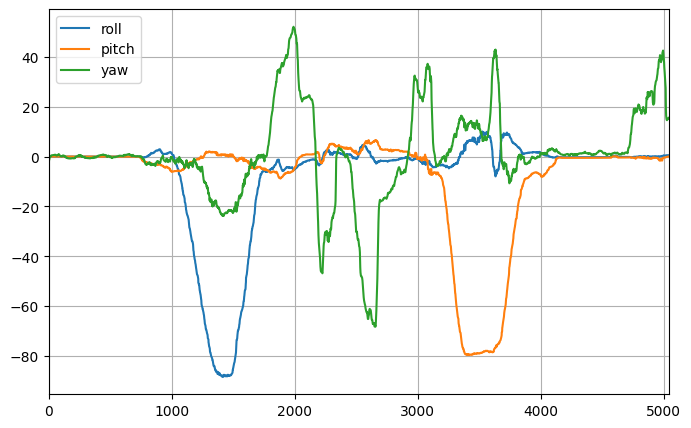

In [11]:
fig = plt.figure()
plt.plot(info['RPY'][:, 0], label='roll')
plt.plot(info['RPY'][:, 1], label='pitch')
plt.plot(info['RPY'][:, 2], label='yaw')
plt.legend()
plt.grid()
plt.xlim([0, len(info['RPY'])])
plt.show()

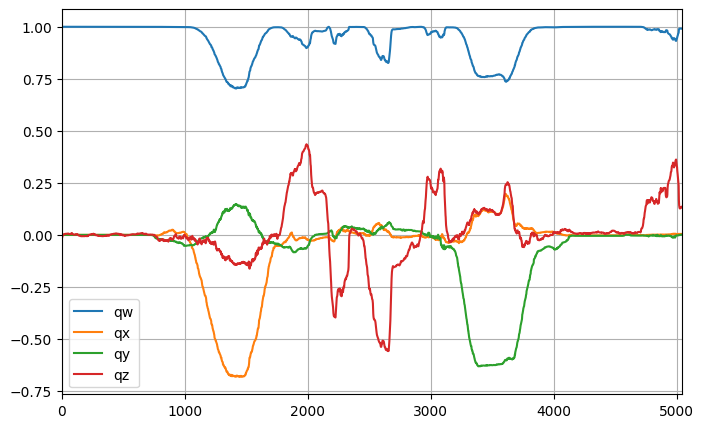

In [12]:
fig = plt.figure()
plt.plot(info['xHat'][:, 0:4], label=['qw', 'qx', 'qy', 'qz'])
plt.legend()
plt.xlim([0, len(info['RPY'])])
plt.grid()
plt.show()

In [14]:
np.mean(info['err'])

0.14620358044146378

# EKF Visualization

In [15]:
data = np.concatenate((w_filt[:, :], a_filt[:, :], m_filt[:, :]), axis=1)

sys = EKF(quaternion0=quaternion0,
          bias0=bias0,
          acc_ref=a0,
          mag_ref=m0,
          p=p_value,
          Q=Q_value,
          R=R_value)

run(sys, data, Ts)